In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [17:59:08] Enabling RDKit 2019.09.3 jupyter extensions
[17:59:08] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [3]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

number of all smiles:  1484
not successfully processed smiles:  [NH4][Pt]([NH4])(Cl)Cl
not successfully processed smiles:  c1ccc(cc1)n2c(=O)c(c(=O)n2c3ccccc3)CCS(=O)c4ccccc4


not successfully processed smiles:  Cc1cc2c(cc1C)N3C=N2[Co+]456(N7=C8[C@H](C(C7=CC9=N4C(=C(C1=N5[C@@]([C@@H]2N6C(=C8C)[C@@]([C@H]2CC(=O)N)(CCC(=O)NC[C@H](OP(=O)(O[C@@H]2[C@H](O[C@H]3[C@@H]2O)CO)[O-])C)C)([C@@]([C@@H]1CCC(=O)N)(C)CC(=O)N)C)C)[C@@]([C@@H]9CCC(=O)N)(C)CC(=O)N)(C)C)CCC(=O)N)O
not successfully processed smiles:  Cc1cc2c(cc1C)N3C=N2[Co]456(N7=C8[C@H](C(C7=CC9=N4C(=C(C1=N5[C@@]([C@@H]2N6C(=C8C)[C@@]([C@H]2CC(=O)N)(CCC(=O)NC[C@H](OP(=O)(O[C@@H]2[C@H](O[C@H]3[C@@H]2O)CO)O)C)C)([C@@]([C@@H]1CCC(=O)N)(C)CC(=O)N)C)C)[C@@]([C@@H]9CCC(=O)N)(C)CC(=O)N)(C)C)CCC(=O)N)C#N
not successfully processed smiles:  CCCCc1c(=O)n(n(c1=O)c2ccc(cc2)O)c3ccccc3
not successfully processed smiles:  CCCCc1c(=O)n(n(c1=O)c2ccccc2)c3ccccc3
number of successfully processed smiles:  1478


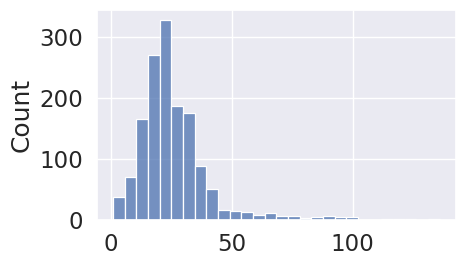

In [4]:
task_name = 'clintox'
tasks = [
    'FDA_APPROVED','CT_TOX'
]
raw_filename = "../data/clintox.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [5]:
random_seed = 888
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.5
fingerprint_dim = 200

radius = 3
T = 3
weight_decay = 3 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

[Se]


N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O


feature dicts file saved as ../data/clintox.pickle


,smiles,FDA_APPROVED,CT_TOX,cano_smiles
12,[Se],0,1,[Se]
20,C(#N)[Fe-2](C#N)(C#N)(C#N)(C#N)N=O,1,0,N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O


In [7]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=3) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=3) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [8]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1146008
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200]

In [9]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall, 


In [10]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.85:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >10) and (epoch - best_param["loss_epoch"] >20):        
        break
        
    train(model, train_df, optimizer, loss_function)


EPOCH:	0
train_roc:[0.34156443966570554, 0.3918756371049949]
valid_roc:[0.3562973484848485, 0.37292321508756177]
train_roc_mean:0.3667200383853502
valid_roc_mean:0.36461028178620514



EPOCH:	1
train_roc:[0.6769952592737403, 0.6471151885830785]
valid_roc:[0.6607481060606061, 0.640547822182308]
train_roc_mean:0.6620552239284094
valid_roc_mean:0.6506479641214571



EPOCH:	2
train_roc:[0.5873552123552124, 0.6734862385321101]
valid_roc:[0.5286458333333333, 0.6989223170184103]
train_roc_mean:0.6304207254436612
valid_roc_mean:0.6137840751758719



EPOCH:	3
train_roc:[0.7219955036410732, 0.6767584097859328]
valid_roc:[0.6834753787878789, 0.7110462505612932]
train_roc_mean:0.6993769567135031
valid_roc_mean:0.697260814674586



EPOCH:	4
train_roc:[0.7102903083915741, 0.6814576962283384]
valid_roc:[0.6725852272727273, 0.6962281095644365]
train_roc_mean:0.6958740023099563
valid_roc_mean:0.6844066684185819



EPOCH:	5
train_roc:[0.6973388397439031, 0.6549745158002038]
valid_roc:[0.6706912878787878, 0.6930848675348001]
train_roc_mean:0.6761566777720535
valid_roc_mean:0.6818880777067939



EPOCH:	6
train_roc:[0.7252822442695861, 0.6799286442405709]
valid_roc:[0.6678503787878788, 0.6971261787157611]
train_roc_mean:0.7026054442550784
valid_roc_mean:0.6824882787518199



EPOCH:	7
train_roc:[0.7235105811055179, 0.6721406727828746]
valid_roc:[0.6749526515151515, 0.6867983834755277]
train_roc_mean:0.6978256269441963
valid_roc_mean:0.6808755174953396



EPOCH:	8
train_roc:[0.7243169933043351, 0.6813557594291539]
valid_roc:[0.6758996212121212, 0.7061068702290076]
train_roc_mean:0.7028363763667445
valid_roc_mean:0.6910032457205644



EPOCH:	9
train_roc:[0.7399809393480279, 0.6913659531090723]
valid_roc:[0.689157196969697, 0.7038616973506959]
train_roc_mean:0.7156734462285501
valid_roc_mean:0.6965094471601965



EPOCH:	10
train_roc:[0.7504887346659498, 0.703190621814475]
valid_roc:[0.6962594696969697, 0.7155365963179166]
train_roc_mean:0.7268396782402125
valid_roc_mean:0.7058980330074431



EPOCH:	11
train_roc:[0.7512951468647671, 0.7059123343527014]
valid_roc:[0.6972064393939393, 0.7182308037718904]
train_roc_mean:0.7286037406087342
valid_roc_mean:0.7077186215829149



EPOCH:	12
train_roc:[0.7575998240555202, 0.7110907237512741]
valid_roc:[0.6953125, 0.7177817691962282]
train_roc_mean:0.7343452739033971
valid_roc_mean:0.706547134598114



EPOCH:	13
train_roc:[0.7649674991447143, 0.7187869520897043]
valid_roc:[0.7090435606060607, 0.7317018410417603]
train_roc_mean:0.7418772256172093
valid_roc_mean:0.7203727008239105



EPOCH:	14
train_roc:[0.772689506866722, 0.729184505606524]
valid_roc:[0.7095170454545454, 0.7343960484957341]
train_roc_mean:0.750937006236623
valid_roc_mean:0.7219565469751398



EPOCH:	15
train_roc:[0.7954645422999853, 0.7548318042813454]
valid_roc:[0.7114109848484849, 0.7281095644364616]
train_roc_mean:0.7751481732906653
valid_roc_mean:0.7197602746424732



EPOCH:	16
train_roc:[0.7879746835443038, 0.7515494393476045]
valid_roc:[0.7459753787878788, 0.7487651549169285]
train_roc_mean:0.7697620614459542
valid_roc_mean:0.7473702668524036



EPOCH:	17
train_roc:[0.8110307414104883, 0.7781549439347605]
valid_roc:[0.7606534090909092, 0.7739110911540188]
train_roc_mean:0.7945928426726243
valid_roc_mean:0.767282250122464



EPOCH:	18
train_roc:[0.8308855872147011, 0.8051987767584098]
valid_roc:[0.7284564393939394, 0.747867085765604]
train_roc_mean:0.8180421819865554
valid_roc_mean:0.7381617625797717



EPOCH:	19
train_roc:[0.8211964224622452, 0.8012538226299695]
valid_roc:[0.7024147727272727, 0.7213740458015268]
train_roc_mean:0.8112251225461073
valid_roc_mean:0.7118944092643997



EPOCH:	20
train_roc:[0.8407213723669419, 0.8179306829765546]
valid_roc:[0.785748106060606, 0.7923215087561742]
train_roc_mean:0.8293260276717482
valid_roc_mean:0.7890348074083902



EPOCH:	21
train_roc:[0.858120326474757, 0.8351681957186544]
valid_roc:[0.7691761363636364, 0.7882801975752133]
train_roc_mean:0.8466442610967058
valid_roc_mean:0.7787281669694248



EPOCH:	22
train_roc:[0.8657690239968723, 0.8413965341488278]
valid_roc:[0.7843276515151515, 0.7986079928154467]
train_roc_mean:0.8535827790728501
valid_roc_mean:0.7914678221652991



EPOCH:	23
train_roc:[0.869972142124041, 0.8468195718654433]
valid_roc:[0.801373106060606, 0.8143242029636282]
train_roc_mean:0.8583958569947421
valid_roc_mean:0.8078486545121171



EPOCH:	24
train_roc:[0.8806754313083428, 0.8593985728848115]
valid_roc:[0.795691287878788, 0.826448136506511]
train_roc_mean:0.8700370020965771
valid_roc_mean:0.8110697121926496



EPOCH:	25
train_roc:[0.8822882557059772, 0.8575637104994903]
valid_roc:[0.8056344696969696, 0.8304894476874719]
train_roc_mean:0.8699259831027337
valid_roc_mean:0.8180619586922208



EPOCH:	26
train_roc:[0.8813596598406725, 0.8577879714576961]
valid_roc:[0.8231534090909092, 0.8412662775033677]
train_roc_mean:0.8695738156491843
valid_roc_mean:0.8322098432971384



EPOCH:	27
train_roc:[0.8874810615316946, 0.8649745158002039]
valid_roc:[0.826467803030303, 0.844409519533004]
train_roc_mean:0.8762277886659493
valid_roc_mean:0.8354386612816536



EPOCH:	28
train_roc:[0.8909877327598847, 0.8679408766564729]
valid_roc:[0.8383049242424243, 0.8529411764705882]
train_roc_mean:0.8794643047081788
valid_roc_mean:0.8456230503565063



EPOCH:	29
train_roc:[0.8982087874492938, 0.8770438328236493]
valid_roc:[0.8349905303030303, 0.8547373147732376]
train_roc_mean:0.8876263101364715
valid_roc_mean:0.8448639225381339



EPOCH:	30
train_roc:[0.9020697913102976, 0.878032619775739]
valid_roc:[0.8397253787878788, 0.8556353839245622]
train_roc_mean:0.8900512055430183
valid_roc_mean:0.8476803813562205



EPOCH:	31
train_roc:[0.9057841747715165, 0.8881345565749236]
valid_roc:[0.8169981060606062, 0.8453075886843288]
train_roc_mean:0.89695936567322
valid_roc_mean:0.8311528473724674



EPOCH:	32
train_roc:[0.9054542788720004, 0.8836289500509683]
valid_roc:[0.8425662878787878, 0.8704535249214189]
train_roc_mean:0.8945416144614844
valid_roc_mean:0.8565099064001034



EPOCH:	33
train_roc:[0.9113313132300475, 0.8921406727828747]
valid_roc:[0.8378314393939394, 0.8605747642568478]
train_roc_mean:0.901735993006461
valid_roc_mean:0.8492031018253936



EPOCH:	34
train_roc:[0.916267533356141, 0.8979306829765544]
valid_roc:[0.8378314393939393, 0.8619218679838349]
train_roc_mean:0.9070991081663478
valid_roc_mean:0.8498766536888871



EPOCH:	35
train_roc:[0.9203240310835248, 0.901763506625892]
valid_roc:[0.8525094696969697, 0.8803322855859901]
train_roc_mean:0.9110437688547084
valid_roc_mean:0.8664208776414799



EPOCH:	36
train_roc:[0.921032696349152, 0.9061467889908256]
valid_roc:[0.8345170454545454, 0.8596766951055232]
train_roc_mean:0.9135897426699888
valid_roc_mean:0.8470968702800343



EPOCH:	37
train_roc:[0.9200430086506035, 0.9009174311926605]
valid_roc:[0.8676609848484849, 0.8825774584643017]
train_roc_mean:0.910480219921632
valid_roc_mean:0.8751192216563932



EPOCH:	38
train_roc:[0.9211060065490445, 0.902691131498471]
valid_roc:[0.8643465909090908, 0.881679389312977]
train_roc_mean:0.9118985690237578
valid_roc_mean:0.873012990111034



EPOCH:	39
train_roc:[0.9303430917354968, 0.9149235474006115]
valid_roc:[0.8548768939393938, 0.8749438706780422]
train_roc_mean:0.9226333195680542
valid_roc_mean:0.8649103823087181



EPOCH:	40
train_roc:[0.9315160549337764, 0.9173088685015289]
valid_roc:[0.8617424242424242, 0.8866187696452628]
train_roc_mean:0.9244124617176527
valid_roc_mean:0.8741805969438434



EPOCH:	41
train_roc:[0.9382483749572358, 0.9250662589194699]
valid_roc:[0.8633996212121211, 0.8879658733722497]
train_roc_mean:0.9316573169383529
valid_roc_mean:0.8756827472921854



EPOCH:	42
train_roc:[0.931919261033185, 0.9190621814475026]
valid_roc:[0.8686079545454546, 0.8996407723394702]
train_roc_mean:0.9254907212403438
valid_roc_mean:0.8841243634424624



EPOCH:	43
train_roc:[0.9372831239919848, 0.924954128440367]
valid_roc:[0.8790246212121211, 0.9158060170633139]
train_roc_mean:0.9311186262161759
valid_roc_mean:0.8974153191377174



EPOCH:	44
train_roc:[0.9317726406334, 0.9161569826707441]
valid_roc:[0.8757102272727273, 0.8866187696452628]
train_roc_mean:0.923964811652072
valid_roc_mean:0.881164498458995



EPOCH:	45
train_roc:[0.9356947363276478, 0.9208664627930683]
valid_roc:[0.8837594696969697, 0.8955994611585092]
train_roc_mean:0.928280599560358
valid_roc_mean:0.8896794654277395



EPOCH:	46
train_roc:[0.9384683055569131, 0.9263404689092762]
valid_roc:[0.8690814393939394, 0.8964975303098338]
train_roc_mean:0.9324043872330947
valid_roc_mean:0.8827894848518867



EPOCH:	47
train_roc:[0.9421215971848884, 0.9335474006116207]
valid_roc:[0.8714488636363635, 0.8960484957341716]
train_roc_mean:0.9378344988982545
valid_roc_mean:0.8837486796852676



EPOCH:	48
train_roc:[0.945982601045892, 0.9360346585117229]
valid_roc:[0.8818655303030303, 0.9027840143691064]
train_roc_mean:0.9410086297788074
valid_roc_mean:0.8923247723360683



EPOCH:	49
train_roc:[0.9494770539074336, 0.941539245667686]
valid_roc:[0.8757102272727273, 0.8973955994611585]
train_roc_mean:0.9455081497875598
valid_roc_mean:0.886552913366943



EPOCH:	50
train_roc:[0.9525072088363227, 0.9437104994903158]
valid_roc:[0.8802083333333333, 0.8973955994611585]
train_roc_mean:0.9481088541633192
valid_roc_mean:0.888801966397246



EPOCH:	51
train_roc:[0.9540100679341185, 0.9463404689092763]
valid_roc:[0.8809185606060606, 0.8929052537045352]
train_roc_mean:0.9501752684216973
valid_roc_mean:0.8869119071552979



EPOCH:	52
train_roc:[0.9579566003616636, 0.95]
valid_roc:[0.8790246212121212, 0.8906600808262237]
train_roc_mean:0.9539783001808317
valid_roc_mean:0.8848423510191725



EPOCH:	53
train_roc:[0.9530814720688138, 0.9443934760448521]
valid_roc:[0.8946496212121212, 0.9099685675797036]
train_roc_mean:0.948737474056833
valid_roc_mean:0.9023090943959124



EPOCH:	54
train_roc:[0.9605835491911442, 0.9529051987767583]
valid_roc:[0.8918087121212122, 0.8991917377638078]
train_roc_mean:0.9567443739839512
valid_roc_mean:0.8955002249425099



EPOCH:	55
train_roc:[0.9605224573579003, 0.9527726809378185]
valid_roc:[0.8903882575757576, 0.9000898069151325]
train_roc_mean:0.9566475691478594
valid_roc_mean:0.8952390322454451



EPOCH:	56
train_roc:[0.96140217975661, 0.9527930682976555]
valid_roc:[0.8960700757575757, 0.9054782218230804]
train_roc_mean:0.9570976240271327
valid_roc_mean:0.900774148790328



EPOCH:	57
train_roc:[0.9639924734861444, 0.9582670744138634]
valid_roc:[0.8861268939393939, 0.8991917377638078]
train_roc_mean:0.9611297739500039
valid_roc_mean:0.8926593158516009



EPOCH:	58
train_roc:[0.9651654366844241, 0.9588888888888889]
valid_roc:[0.8809185606060606, 0.8893129770992365]
train_roc_mean:0.9620271627866566
valid_roc_mean:0.8851157688526485



EPOCH:	59
train_roc:[0.9649943795513415, 0.9565851172273191]
valid_roc:[0.8934659090909091, 0.8973955994611584]
train_roc_mean:0.9607897483893303
valid_roc_mean:0.8954307542760338



EPOCH:	60
train_roc:[0.9647255754850692, 0.9560958205912333]
valid_roc:[0.907907196969697, 0.9193982936686126]
train_roc_mean:0.9604106980381513
valid_roc_mean:0.9136527453191547



EPOCH:	61
train_roc:[0.9596182982258932, 0.953394495412844]
valid_roc:[0.8965435606060606, 0.9095195330040413]
train_roc_mean:0.9565063968193686
valid_roc_mean:0.9030315468050509



EPOCH:	62
train_roc:[0.9653975856507501, 0.9573904179408768]
valid_roc:[0.9098011363636364, 0.9140098787606645]
train_roc_mean:0.9613940017958134
valid_roc_mean:0.9119055075621505



EPOCH:	63
train_roc:[0.9639558183861981, 0.9568909276248725]
valid_roc:[0.8963068181818181, 0.9126627750336775]
train_roc_mean:0.9604233730055354
valid_roc_mean:0.9044847966077478



EPOCH:	64
train_roc:[0.9680978446801233, 0.9618756371049948]
valid_roc:[0.9074337121212122, 0.927031881454872]
train_roc_mean:0.964986740892559
valid_roc_mean:0.917232796788042



EPOCH:	65
train_roc:[0.9686232344460192, 0.9646788990825689]
valid_roc:[0.8861268939393939, 0.9009878760664571]
train_roc_mean:0.966651066764294
valid_roc_mean:0.8935573850029255



EPOCH:	66
train_roc:[0.9625507062215924, 0.9539551478083588]
valid_roc:[0.9095643939393939, 0.927031881454872]
train_roc_mean:0.9582529270149756
valid_roc_mean:0.918298137697133



EPOCH:	67
train_roc:[0.9712501832754998, 0.9645667686034658]
valid_roc:[0.8984375, 0.9081724292770543]
train_roc_mean:0.9679084759394828
valid_roc_mean:0.9033049646385272



EPOCH:	68
train_roc:[0.9633937735203558, 0.9549031600407748]
valid_roc:[0.9197443181818182, 0.9202963628199372]
train_roc_mean:0.9591484667805653
valid_roc_mean:0.9200203405008778



EPOCH:	69
train_roc:[0.9659474121499438, 0.9584913353720693]
valid_roc:[0.9036458333333334, 0.9126627750336775]
train_roc_mean:0.9622193737610065
valid_roc_mean:0.9081543041835054



EPOCH:	70
train_roc:[0.9713968036752847, 0.9652803261977574]
valid_roc:[0.8809185606060606, 0.885720700493938]
train_roc_mean:0.968338564936521
valid_roc_mean:0.8833196305499993



EPOCH:	71
train_roc:[0.9653609305508039, 0.9588685015290519]
valid_roc:[0.9183238636363636, 0.9315222272114952]
train_roc_mean:0.9621147160399279
valid_roc_mean:0.9249230454239294



EPOCH:	72
train_roc:[0.9689531303455353, 0.9651274209989806]
valid_roc:[0.9083806818181819, 0.9207453973955995]
train_roc_mean:0.967040275672258
valid_roc_mean:0.9145630396068907



EPOCH:	73
train_roc:[0.9718977567078831, 0.9671355759429154]
valid_roc:[0.9036458333333334, 0.9171531207903009]
train_roc_mean:0.9695166663253993
valid_roc_mean:0.9103994770618171



EPOCH:	74
train_roc:[0.9728385709398368, 0.9677166156982671]
valid_roc:[0.9105113636363636, 0.9252357431522227]
train_roc_mean:0.970277593319052
valid_roc_mean:0.9178735533942932



EPOCH:	75
train_roc:[0.9733395239724353, 0.9692558613659531]
valid_roc:[0.9026988636363636, 0.9144589133363269]
train_roc_mean:0.9712976926691942
valid_roc_mean:0.9085788884863453



EPOCH:	76
train_roc:[0.9730585015395141, 0.9687971457696227]
valid_roc:[0.9131155303030303, 0.9274809160305344]
train_roc_mean:0.9709278236545684
valid_roc_mean:0.9202982231667823



EPOCH:	77
train_roc:[0.9738282586383852, 0.9693577981651376]
valid_roc:[0.8989109848484849, 0.9090704984283791]
train_roc_mean:0.9715930284017613
valid_roc_mean:0.903990741638432



EPOCH:	78
train_roc:[0.9704315527100338, 0.9641080530071355]
valid_roc:[0.9038825757575757, 0.9027840143691065]
train_roc_mean:0.9672698028585847
valid_roc_mean:0.903333295063341



EPOCH:	79
train_roc:[0.9749401300034212, 0.9699898063200815]
valid_roc:[0.9008049242424243, 0.9135608441850023]
train_roc_mean:0.9724649681617513
valid_roc_mean:0.9071828842137133



EPOCH:	80
train_roc:[0.9749401300034212, 0.9701936799184505]
valid_roc:[0.9173768939393939, 0.9301751234845084]
train_roc_mean:0.9725669049609358
valid_roc_mean:0.9237760087119511



EPOCH:	81
train_roc:[0.9768950686672205, 0.9725280326197758]
valid_roc:[0.8913352272727273, 0.9041311180960934]
train_roc_mean:0.9747115506434982
valid_roc_mean:0.8977331726844103



EPOCH:	82
train_roc:[0.9705659547431699, 0.9667074413863405]
valid_roc:[0.8889678030303031, 0.8987427031881454]
train_roc_mean:0.9686366980647552
valid_roc_mean:0.8938552531092243



In [11]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_losses = eval(model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:71
test_roc:[0.9471264367816092, 0.9444444444444444]
test_roc_mean: 0.9457854406130268
